In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from fredapi import Fred
import pingouin as pg
import time
from scipy import stats

# House price and racial demographics in US counties

First, we want to get all the house price data from the FRED API, because there is more than 3000 county in the US, while FRED only has 2000 counties' data. Some of the counties will have less Asian population, which is small enough that we ignore them.

In [245]:
fred = Fred(api_key= 'ecc7334e54825a69e5f1e8e911f9ae03')
search1 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='search_rank')
search2 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='popularity')
search3 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='series_id', sort_order='asc')
search4 = fred.search('All-Transactions House Price Index county', filter =('frequency', 'Annual'), order_by='series_id', sort_order='desc')
search = pd.concat([search1, search2, search3,search4], axis=0).drop_duplicates()
search.shape

(2111, 15)

In [246]:
search['title'] = search.title.str.replace('All-Transactions House Price Index for ','')
county_names = search.title.str.split(',', expand=True)
county_names.rename(columns={0: 'county', 1:'state'}, inplace=True)

In [247]:
search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
ATNHPIUS06037A,ATNHPIUS06037A,2023-02-20,2023-02-20,"Los Angeles County, CA",1975-01-01,2021-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2022-03-29 09:02:03-05:00,55,"As stated by the source, these annual county i..."
ATNHPIUS06059A,ATNHPIUS06059A,2023-02-20,2023-02-20,"Orange County, CA",1975-01-01,2021-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2022-03-29 09:02:03-05:00,43,"As stated by the source, these annual county i..."
ATNHPIUS36119A,ATNHPIUS36119A,2023-02-20,2023-02-20,"Westchester County, NY",1975-01-01,2021-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2022-03-29 09:02:04-05:00,25,"As stated by the source, these annual county i..."
ATNHPIUS53033A,ATNHPIUS53033A,2023-02-20,2023-02-20,"King County, WA",1975-01-01,2021-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2022-03-29 09:01:02-05:00,23,"As stated by the source, these annual county i..."
ATNHPIUS06083A,ATNHPIUS06083A,2023-02-20,2023-02-20,"Santa Barbara County, CA",1975-01-01,2021-01-01,Annual,A,Index 2000=100,Index 2000=100,Not Seasonally Adjusted,NSA,2022-03-29 09:02:08-05:00,20,"As stated by the source, these annual county i..."


In [248]:
# all_results = []
#
# for myid in search['id']:
#     results = fred.get_series(myid)
#     results = results.to_frame(name = myid)
#     all_results.append(results)
#     time.sleep(0.3)
#
# housing_result = pd.concat(all_results, axis = 1)

In [249]:
housing_result = pd.read_csv('uscensus_data/housing_result_2000.csv')

In [250]:
housing_result_t = housing_result.transpose()
housing_result_t = housing_result_t.merge(county_names, left_index = True, right_on = 'series id',)

In [251]:
housing_result_t['price_change'] = (housing_result_t.iloc[:,-3] - housing_result_t.iloc[:,-14])/housing_result_t.iloc[:,-14]*100
housing_price_change = housing_result_t.iloc[:, -3:]

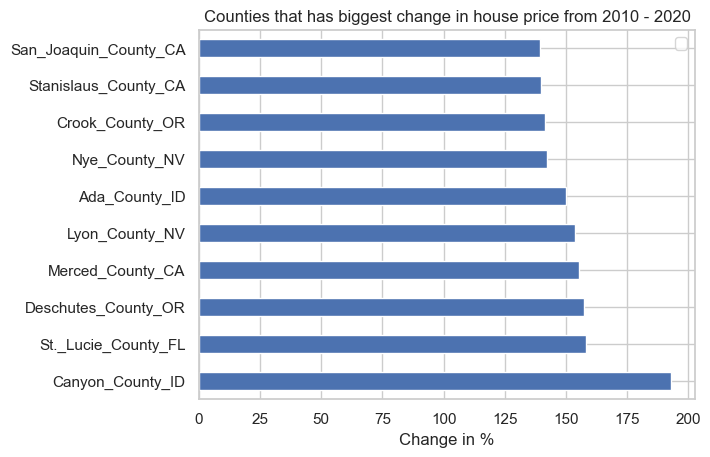

In [252]:
housing_price_change['county_state'] = housing_price_change.county.str.replace(' ','_') + '_' + housing_price_change.state.str.strip()
df = housing_price_change.sort_values(by = 'price_change', ascending = False).head(10)
df.plot(kind = 'barh', x='county_state')
plt.title('Counties that has biggest change in house price from 2010 - 2020')
plt.ylabel(None)
plt.xlabel('Change in %')
plt.legend('')
plt.show()

We didn't consider other factors here, only looking at the change in house price. There are a few states that have shown up a lot. Canyon County, Idaho, has the most significant change, which is around a 190% change in house prices. Counties in Idaho appear 3 times in this graph, the same applies to California, which also appears 3 times, where Merced County ranked No. 4 in the change in house price. Nevada appears 2 times, we will notice that the states like Idaho and Nevada, which are not seen as typical rich states, have some big changes. We will dig deeper after we consider other factors.

## Cleaning all the census data

In [253]:
census_2010 = pd.read_csv('uscensus_data/DECENNIALPL2010.P1-2023-02-09T171005.csv')
census_2020 = pd.read_csv('uscensus_data/DECENNIALPL2020.P1-2023-02-09T165840.csv')
census_2010_t = census_2010.T
census_2020_t = census_2020.T

In [254]:
hispanic_2010 = pd.read_csv('uscensus_data/2010_hispanic.csv')
hispanic_2020 = pd.read_csv('uscensus_data/2020_hispanic.csv')
hispanic_2010_t = hispanic_2010.T
hispanic_2020_t = hispanic_2020.T

In [255]:
hispanic_2010_t.columns = hispanic_2010_t.iloc[0]
hispanic_2010_t = hispanic_2010_t.drop(hispanic_2010_t.index[0])
hispanic_2020_t.columns = hispanic_2020_t.iloc[0]
hispanic_2020_t = hispanic_2020_t.drop(hispanic_2020_t.index[0])

In [256]:
census_2010_t.columns = census_2010_t.iloc[0]
census_2010_t = census_2010_t.drop(census_2010_t.index[0])
census_2020_t.columns = census_2020_t.iloc[0]
census_2020_t = census_2020_t.drop(census_2020_t.index[0])

In [257]:
%%capture
h_2010 = hispanic_2010_t.reset_index()
h_2020 = hispanic_2020_t.reset_index()
h_2010 = hispanic_2010_t.iloc[:, 1:2]
h_2020 = hispanic_2020_t.iloc[:, 1:2]
h_2010['year'] = 2010
h_2020['year'] = 2020
h_2010 = h_2010.reset_index()
h_2020 = h_2020.reset_index()

In [258]:
%%capture
c_2010 = census_2010_t.iloc[:, :8]
c_2020 = census_2020_t.iloc[:, :8]
c_2010['year'] = 2010
c_2020['year'] = 2020
c_2010 = c_2010.reset_index()
c_2020 = c_2020.reset_index()

In [259]:
hisp = pd.concat([h_2010,h_2020])
hisp.columns = ['county','hisp','year']

In [260]:
hisp = hisp.pivot(index = 'county', columns = 'year')

In [261]:
df = pd.concat([c_2010,c_2020])
df.columns = ['county', 'total','total_one', 'wh','bl','na','as','ha','o','year']

In [262]:
df = df.pivot(index = 'county', columns = 'year', values = ['total','total_one', 'wh','bl','na','as','ha','o'])
# Can't do any calculation on old data, have to transform them.

In [263]:
df = df.merge(hisp, left_index=True, right_index=True)

In [264]:
df.head()

total          total_one           \
year                                 2010     2020      2010     2020   
county                                                                  
Abbeville County, South Carolina   25,417   24,295    25,126   23,408   
Acadia Parish, Louisiana           61,773   57,576    60,957   55,603   
Accomack County, Virginia          33,164   33,413    32,625   31,655   
Ada County, Idaho                 392,365  494,967   381,195  453,110   
Adair County, Iowa                  7,682    7,496     7,630    7,262   

                                       wh               bl            na  \
year                                 2010     2020    2010   2020   2010   
county                                                                     
Abbeville County, South Carolina   17,691   16,877   7,187  6,205     60   
Acadia Parish, Louisiana           49,127   44,480  11,175  9,989    163   
Accomack County, Virginia          21,662   20,261   9,303  8,670    135   
Ada County, Idaho                 354,347  410,263   4,441  8,058  2,610   
Adair County, Iowa                  7,558    7,149      11     46      4   

                                            as           ha             o  \
year                               2020   2010    2020 2010   2020   2010   
county                                                                      
Abbeville County, South Carolina     44     75      73    5     11    108   
Acadia Parish, Louisiana            152    137     163    6      2    349   
Accomack County, Virginia           297    183     255   40      4  1,302   
Ada County, Idaho                 3,274  9,407  13,929  861  1,318  9,529   
Adair County, Iowa                   19     22      23    1      2     34   

                                            hisp          
year                                2020    2010    2020  
county                                                    
Abbeville County, South Carolina     198     255     423  
Acadia Parish, Louisiana             817   1,060   1,641  
Accomack County, Virginia          2,168   2,850   3,430  
Ada County, Idaho                 16,268  27,905  45,223  
Adair County, Iowa                    23     101     186

For reference, wh is 'White', bl is 'Black', na is 'Native American', as is 'Asian', ha is 'Native Hawaiian and Other Pacific Islander', o is 'Other', hisp is 'Hispanic'

In [265]:
def convert_to_numeric(col):
    return pd.to_numeric(col.str.replace(',', ''), errors='coerce')
df = df.apply(convert_to_numeric)

In [266]:
df['total_change'] = (df.iloc[:,1] - df.iloc[:,0])/df.iloc[:,0]*100
df['total_1_change'] = (df.iloc[:,3] - df.iloc[:,2])/df.iloc[:,2]*100
df['wh_change'] = (df.iloc[:,5] - df.iloc[:,4])/df.iloc[:,4]*100
df['bl_change'] = (df.iloc[:,7] - df.iloc[:,6])/df.iloc[:,6]*100
df['na_change'] = (df.iloc[:,9] - df.iloc[:,8])/df.iloc[:,8]*100
df['as_change'] = (df.iloc[:,11] - df.iloc[:,10])/df.iloc[:,10]*100
df['ha_change'] = (df.iloc[:,13] - df.iloc[:,12])/df.iloc[:,12]*100
df['o_change'] = (df.iloc[:,15] - df.iloc[:,14])/df.iloc[:,14]*100
df['hisp_change'] = (df.iloc[:,17] - df.iloc[:,16])/df.iloc[:,16]*100

In [267]:
df.reset_index(inplace = True)
df = pd.concat([df.iloc[:,0].str.split(', ', expand = True), df.iloc[:,1:]], axis = 1)

In [268]:
df.columns = ['county','state','total_10','total_20','total_one_10', 'total_one_20','wh_10','wh_20','bl_10','bl_20','na_10','na_20','as_10','as_20','ha_10','ha_20','o_10','o_20','hisp_10','hisp_20','total_change','total_1_change','wh_change','bl_change','na_change','as_change','ha_change','o_change','hisp_change']

In [269]:
# Asked ChatGPT to help me create this list to transform full state name to abbreviation
states = [['Alabama', 'AL'],
          ['Alaska', 'AK'],
          ['Arizona', 'AZ'],
          ['Arkansas', 'AR'],
          ['California', 'CA'],
          ['Colorado', 'CO'],
          ['Connecticut', 'CT'],
          ['Delaware', 'DE'],
          ['District of Columbia', 'DC'],
          ['Florida', 'FL'],
          ['Georgia', 'GA'],
          ['Hawaii', 'HI'],
          ['Idaho', 'ID'],
          ['Illinois', 'IL'],
          ['Indiana', 'IN'],
          ['Iowa', 'IA'],
          ['Kansas', 'KS'],
          ['Kentucky', 'KY'],
          ['Louisiana', 'LA'],
          ['Maine', 'ME'],
          ['Maryland', 'MD'],
          ['Massachusetts', 'MA'],
          ['Michigan', 'MI'],
          ['Minnesota', 'MN'],
          ['Mississippi', 'MS'],
          ['Missouri', 'MO'],
          ['Montana', 'MT'],
          ['Nebraska', 'NE'],
          ['Nevada', 'NV'],
          ['New Hampshire', 'NH'],
          ['New Jersey', 'NJ'],
          ['New Mexico', 'NM'],
          ['New York', 'NY'],
          ['North Carolina', 'NC'],
          ['North Dakota', 'ND'],
          ['Ohio', 'OH'],
          ['Oklahoma', 'OK'],
          ['Oregon', 'OR'],
          ['Pennsylvania', 'PA'],
          ['Rhode Island', 'RI'],
          ['South Carolina', 'SC'],
          ['South Dakota', 'SD'],
          ['Tennessee', 'TN'],
          ['Texas', 'TX'],
          ['Utah', 'UT'],
          ['Vermont', 'VT'],
          ['Virginia', 'VA'],
          ['Washington', 'WA'],
          ['West Virginia', 'WV'],
          ['Wisconsin', 'WI'],
          ['Wyoming', 'WY']]
states_index = pd.DataFrame(states, columns=['Full', 'Abb'])

In [270]:
df = df.merge(states_index, how = 'left', left_on='state', right_on= 'Full')
df.drop(columns='Full')
df['county_state']= df.county.str.replace(' ', '_') + '_' + df.Abb

In [271]:
combined = df.merge(housing_price_change, how = 'left', left_on= 'county_state', right_on='county_state')

In [272]:
combined.dropna(inplace = True)
combined['price_change']=pd.to_numeric(combined['price_change'], errors='coerce')
combined.drop(columns=['county_y','state_y','Full'], inplace= True)
combined.rename(columns={'county_x':'county','state_x':'state'}, inplace = True)

In [273]:
# These columns indicate the proportion of population of that race of the county's total population
combined['wh_p_10'] = combined['wh_10'] / combined['total_10']*100
combined['wh_p_20'] = combined['wh_20'] / combined['total_20']*100
combined['bl_p_10'] = combined['bl_10'] / combined['total_10']*100
combined['bl_p_20'] = combined['bl_20'] / combined['total_20']*100
combined['na_p_10'] = combined['na_10'] / combined['total_10']*100
combined['na_p_20'] = combined['na_20'] / combined['total_20']*100
combined['as_p_10'] = combined['as_10'] / combined['total_10']*100
combined['as_p_20'] = combined['as_20'] / combined['total_20']*100
combined['ha_p_10'] = combined['ha_10'] / combined['total_10']*100
combined['ha_p_20'] = combined['ha_20'] / combined['total_20']*100
combined['o_p_10'] = combined['o_10'] / combined['total_10']*100
combined['o_p_20'] = combined['o_20'] / combined['total_20']*100
combined['hisp_p_10'] = combined['hisp_10'] / combined['total_10']*100
combined['hisp_p_20'] = combined['hisp_20'] / combined['total_20']*100

In [274]:
# These columns indicate the change in proportion of population of that race
# There might be a change in each race's population in one county, but the population composition may remain the same.
combined['wh_p_change_20'] = combined['wh_p_20'] - combined['wh_p_10']
combined['bl_p_change_20'] = combined['bl_p_20'] - combined['bl_p_10']
combined['na_p_change_20'] = combined['na_p_20'] - combined['na_p_10']
combined['as_p_change_20'] = combined['as_p_20'] - combined['as_p_10']
combined['ha_p_change_20'] = combined['ha_p_20'] - combined['ha_p_10']
combined['o_p_change_20'] = combined['o_p_20'] - combined['o_p_10']
combined['hisp_p_change_20'] = combined['hisp_p_20'] - combined['hisp_p_10']

Before running all the tests, I realized that, most likely, house prices will increase instead of decrease in most situations throughout 10 years. If you check housing prices from 2000 and 2010, although there was a decrease during the 2008 financial crisis, housing price change is still positive. While everything is positive makes us difficult to find out the difference and impact of demographic change. While looking at the histogram, we can observe a right skewness for house price change. I decide to use the median as the benchmark, if the house price changes larger than the median change, it will be positive, and smaller than the median will become negative. I call it an adjusted price.

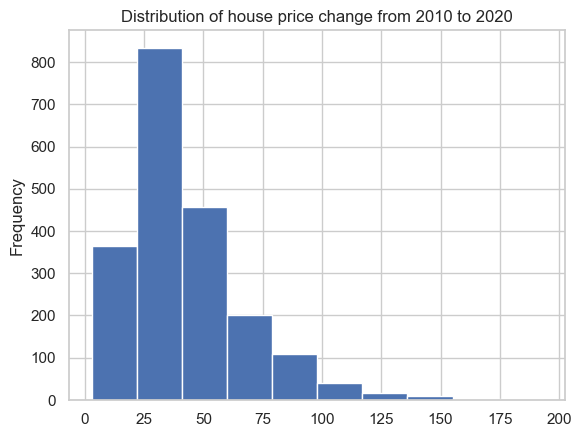

In [275]:
combined.price_change.plot(kind='hist')
plt.title('Distribution of house price change from 2010 to 2020')
plt.show()

In [276]:
combined['adj_price_change'] = combined.price_change - combined.price_change.median()

Finally, we clean up all the data (pivot is difficulty to use in Pandas)

In [277]:
combined.head()

,county,state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,...,hisp_p_10,hisp_p_20,wh_p_change_20,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,adj_price_change
0,Abbeville County,South Carolina,25417.0,24295.0,25126.0,23408.0,17691.0,16877.0,7187.0,6205.0,...,1.003266,1.741099,-0.136053,-2.736116,-0.054955,0.005395,0.025605,0.390070,0.737833,-5.909859
1,Acadia Parish,Louisiana,61773.0,57576.0,60957.0,55603.0,49127.0,44480.0,11175.0,9989.0,...,1.715960,2.850146,-2.273861,-0.741185,0.000130,0.061324,-0.006239,0.854022,1.134186,-15.020617
2,Accomack County,Virginia,33164.0,33413.0,32625.0,31655.0,21662.0,20261.0,9303.0,8670.0,...,8.593656,10.265466,-4.679739,-2.103517,0.481808,0.211373,-0.108641,2.562549,1.671810,-17.189900
3,Ada County,Idaho,392365.0,494967.0,381195.0,453110.0,354347.0,410263.0,4441.0,8058.0,...,7.112000,9.136569,-7.423613,0.496133,-0.003739,0.416614,0.046842,0.858078,2.024568,113.358011
4,Adair County,Iowa,7682.0,7496.0,7630.0,7262.0,7558.0,7149.0,11.0,46.0,...,1.314762,2.481323,-3.014973,0.470469,0.201399,0.020447,0.013663,-0.135763,1.166562,-0.554620


## Take a look at the big picture of our data

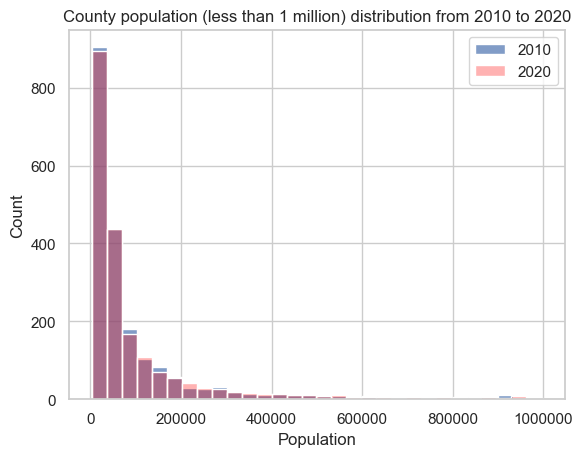

In [278]:
sns.histplot(combined.query("total_10 <1000000"), x='total_10', alpha = 0.7, label = '2010', bins = 30)
sns.histplot(combined.query("total_20 <1000000"), x='total_20', color = 'red', alpha = 0.3, label = '2020', bins = 30)
plt.legend()
plt.title('County population (less than 1 million) distribution from 2010 to 2020')
plt.xlabel('Population')
plt.ticklabel_format(style='plain', axis='x')

Looks like for counties with a population of less than 1 million, there is a small change. Further range's county numbers can offset with each other.

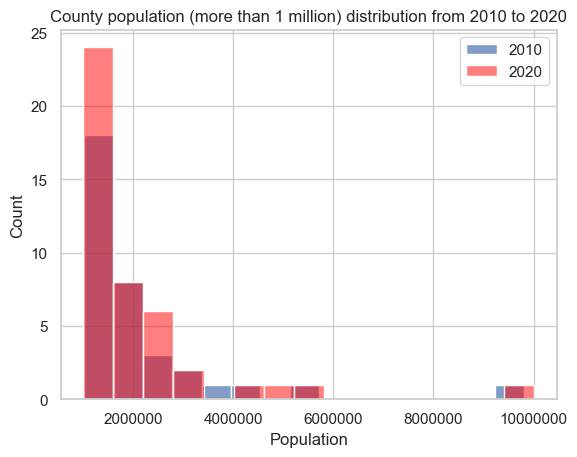

In [279]:
sns.histplot(combined.query("total_10 >1000000"), x='total_10', alpha = 0.7, label = '2010', bins = 15)
sns.histplot(combined.query("total_20 >1000000"), x='total_20', color = 'red', alpha = 0.5, label = '2020', bins = 15)
sns.set_theme(style="whitegrid", palette=None)
plt.legend()
plt.title('County population (more than 1 million) distribution from 2010 to 2020')
plt.xlabel('Population')
plt.ticklabel_format(style='plain', axis='x')

For counties with a population over 1 million, five more counties show up with a population of around 2 million, and there are 2 new counties with 2.5 million population. Let's take a look at what are these counties:

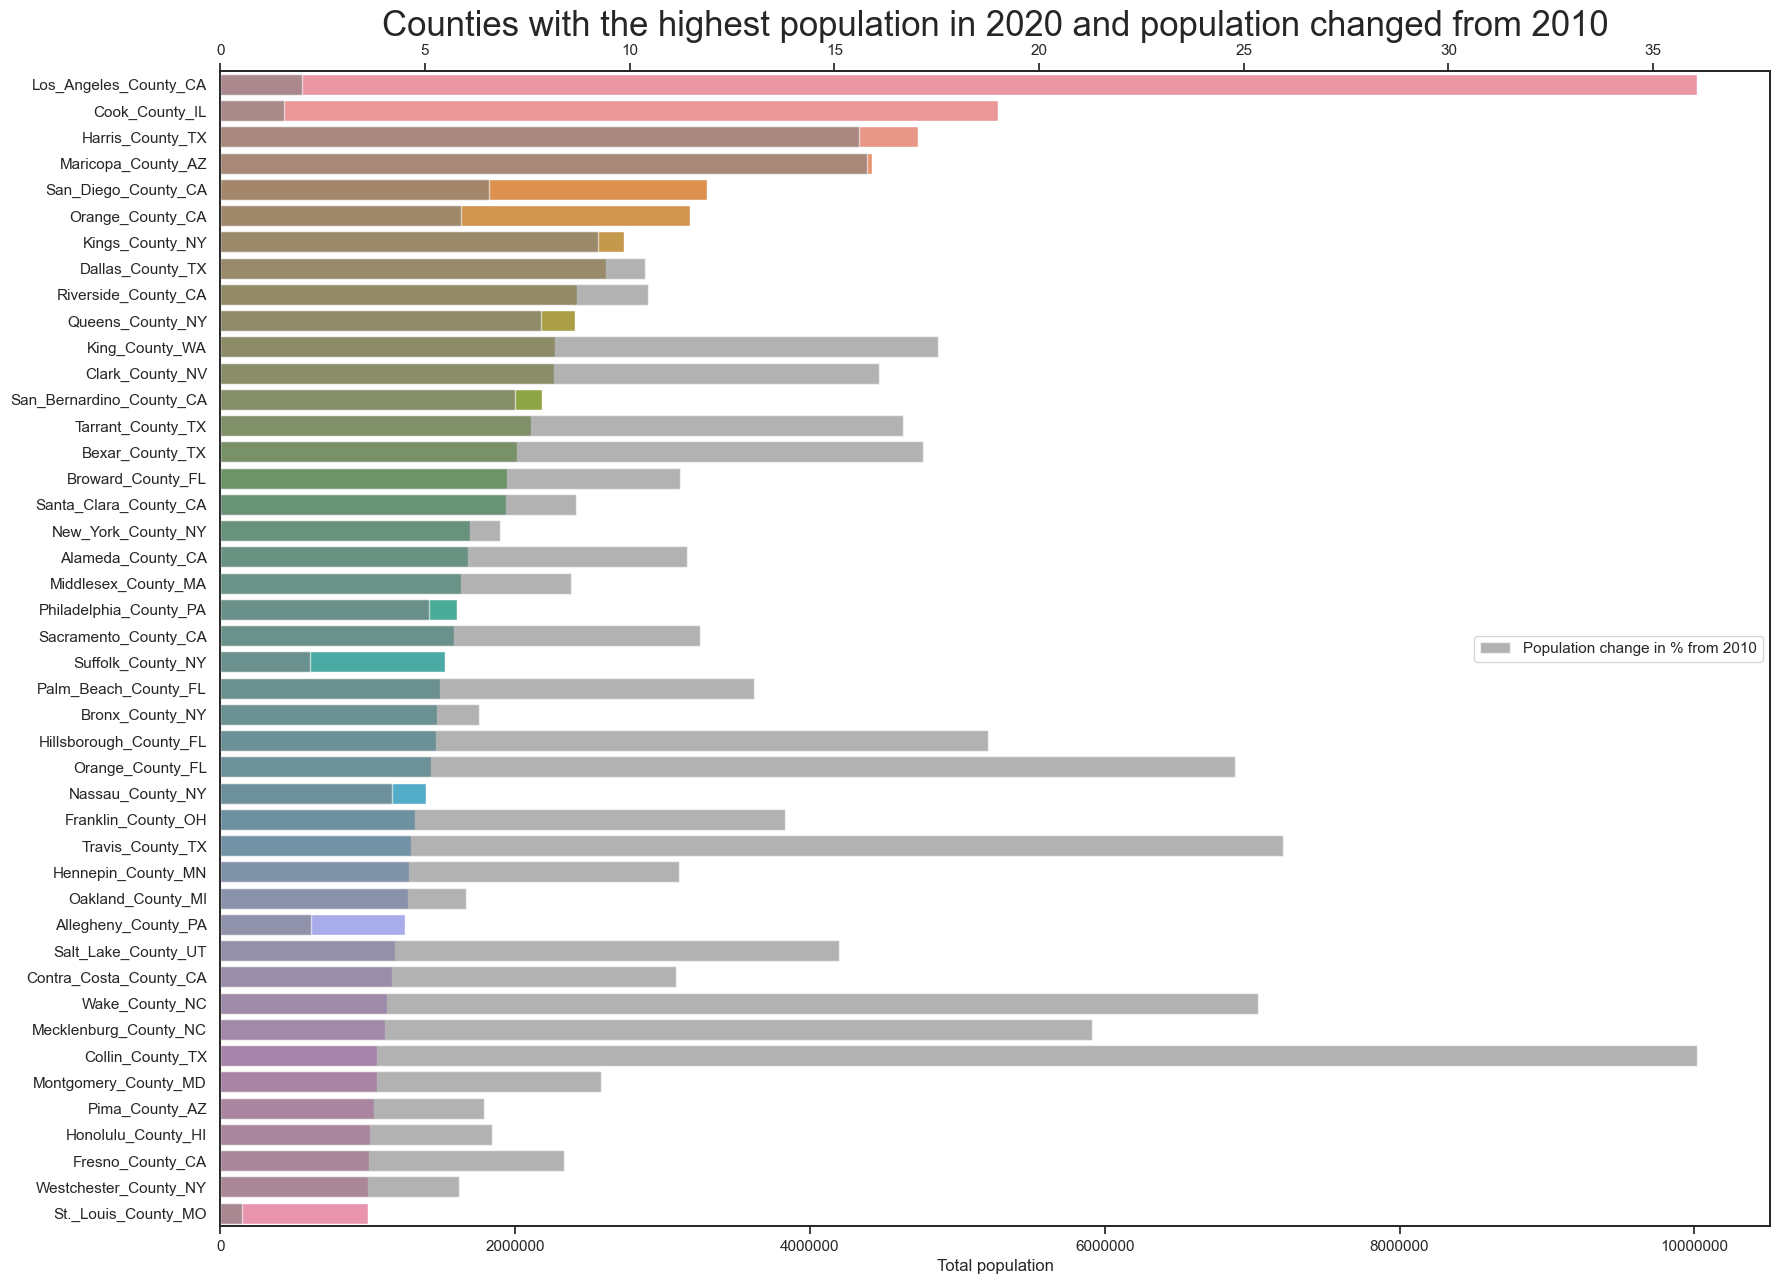

In [280]:
plt.figure(figsize=(20,15))
sns.set_theme(style="white", palette=None)
ax1 = sns.barplot(combined.query('total_20>1000000').sort_values('total_20', ascending= False), y= 'county_state', x= 'total_20')
ax2 = plt.twiny()
sns.barplot(combined.query('total_20>1000000').sort_values('total_20', ascending= False), y= 'county_state', x= 'total_change', ax = ax2, color = 'grey', alpha = 0.6, label = 'Population change in % from 2010')
plt.legend(loc = 'center right')
plt.title('Counties with the highest population in 2020 and population changed from 2010',  fontsize=25)
ax1.set_ylabel('')
plt.xlabel('hello')
ax1.set_xlabel('Total population')
ax2.set_xlabel('')
ax1.ticklabel_format(style='plain', axis='x')

Looking at the graph of counties with a population higher than 1 million in 2020. We can observe some trends. Counties with lower populations tend to have a higher rate of newcomers. Except for St. Louis county (where the city of St. Louis placed), Allegheny County (where the city of Pittsburgh places), Nassau County (site at Long Island, NY), and Suffolk County (next to Nassau County), all other counties has a higher than 5% increased in population, while Collin County, TX (next to Dallas) has an increase rate of 35%. On the other hand, the 2 counties with the top population, Los Angeles County and Cook County (where Chicago places) have a minimal increase, only 2%.

## Finding the relationship between change in county racial composition  and house price by looking at all counties

In [281]:
combined.query('bl_change > 1000')

,county,state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,...,hisp_p_10,hisp_p_20,wh_p_change_20,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,adj_price_change
3144,Williams County,North Dakota,22398.0,40950.0,21754.0,37413.0,20639.0,31854.0,63.0,2096.0,...,1.946602,9.516484,-14.359074,4.837162,-1.08579,1.200403,0.224319,3.420875,7.569881,47.949202


After plotting the scatter plot for black population change and house price change, we find a consistent appear outlier with a change in the black population of more than 3000%! Same for Asians, Native Hawaiian, and Other Pacific Islanders, and other races. Looking at the total population change, which is around 82.8% increase, we can see why there is a drastic change in other races. The reason is that the North Dakota oil boom, after the discovery of the Parshall Oil Field in 2006, attracted many workers to this place. For the sake of analysis, I will drop this county for future analysis.

In [282]:
combined = combined.drop(index = 3144)

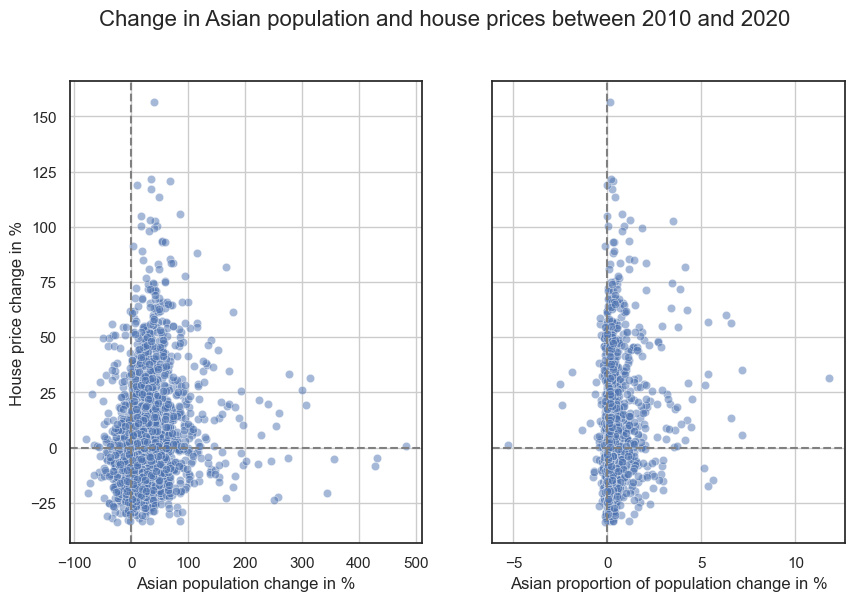

In [283]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x='as_change', y='adj_price_change', alpha = 0.5, ax = ax1)
sns.scatterplot(combined, x='as_p_change_20', y='adj_price_change', alpha = 0.5, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Change in Asian population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [284]:
pg.corr(combined['as_change'], combined['price_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,2031,0.200388,"[0.16, 0.24]",7.660045e-20,1.0


In [285]:
pg.corr(combined['as_p_change_20'], combined['price_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,2031,0.155791,"[0.11, 0.2]",1.667608e-12,1.0


In [286]:
pg.linear_regression(combined['as_change'], combined['price_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,39.763306,0.646351,61.519678,0.000000e+00,0.018677,0.018193,38.495725,41.030887
1,as_change,0.073017,0.011750,6.214260,6.240550e-10,0.018677,0.018193,0.049974,0.096060


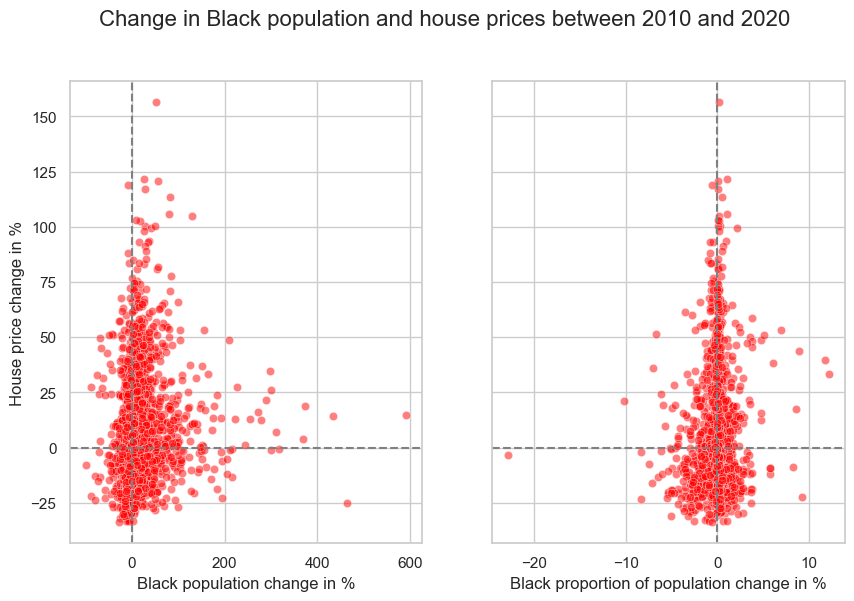

In [287]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x='bl_change', y='adj_price_change', alpha = 0.5, color = 'red', ax = ax1)
sns.scatterplot(combined, x='bl_p_change_20', y='adj_price_change', alpha = 0.5, color = 'red',ax = ax2)
fig.suptitle('Change in Black population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Black population change in %')
ax2.set_xlabel('Black proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [288]:
pg.corr(combined['bl_change'], combined['price_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,2031,0.232386,"[0.19, 0.27]",2.620074e-26,1.0


In [289]:
pg.corr(combined['bl_p_change_20'], combined['price_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,2031,0.030889,"[-0.01, 0.07]",0.164056,0.285354


In [290]:
pg.linear_regression(combined['bl_change'], combined['price_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,41.002203,0.559384,73.298891,0.000000e+00,0.017182,0.016698,39.905177,42.099230
1,bl_change,0.066334,0.011138,5.955847,3.041720e-09,0.017182,0.016698,0.044491,0.088176


When we look the change in the black population, interestingly, it has a similar distribution compared to what we saw in the change in the Asian population. The result of the correlation test shows a 0.23 for R, which is larger than what we had in Asian population data and shows a positive, relatively weak, linear relationship. For the linear regression, we got a p-value that is smaller than 0.01, so, as well that there is very strong evidence again the null hypothesis, which is $\beta_1 = 0$, so we can say there is a positive relationship between change in the black population and change in house price.

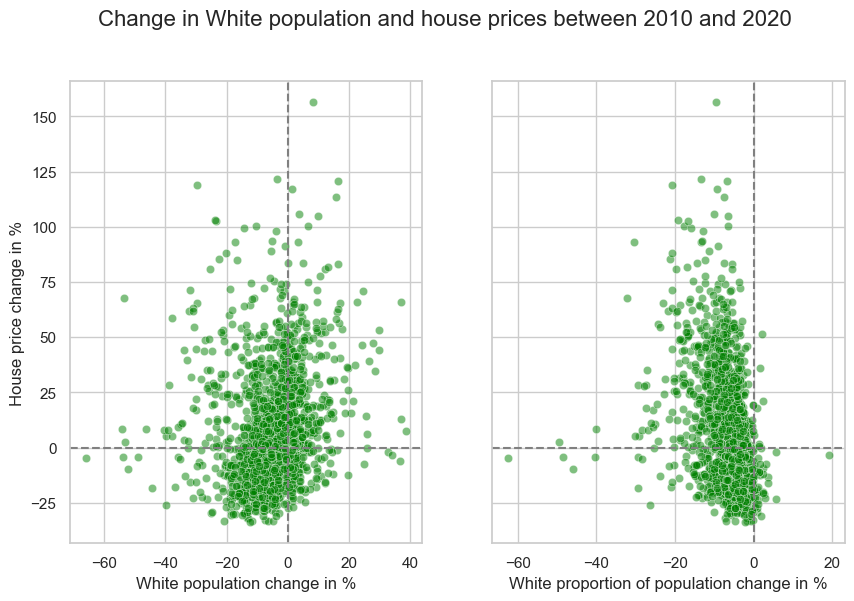

In [291]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x='wh_change', y='adj_price_change', alpha = 0.5, color = 'green', ax = ax1)
sns.scatterplot(combined, x='wh_p_change_20', y='adj_price_change', alpha = 0.5, color = 'green',ax = ax2)
fig.suptitle('Change in White population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('White population change in %')
ax2.set_xlabel('White proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [292]:
pg.corr(combined['wh_change'], combined['price_change'], method="spearman")

,n,r,CI95%,p-val,power
spearman,2031,0.308942,"[0.27, 0.35]",3.626313e-46,1.0


In [293]:
pg.linear_regression(combined['wh_change'], combined['price_change'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,44.84338,0.608052,73.749287,0.000000e+00,0.038634,0.038161,43.650909,46.035851
1,wh_change,0.49520,0.054840,9.029919,3.890900e-19,0.038634,0.038161,0.387651,0.602748


Here is something very different compared to what we saw in Asian and black population change, the population change does not vary that much since the white population is the majority in most counties, and it makes the correlation around 0.3, which is higher than the Asian and black population. For the omitted linear regression, we got a p-value that is smaller than 0.01, so, as well that there is very strong evidence again the null hypothesis, which is $\beta_1 = 0$, so we can say there is a positive relationship between change in the black population and change in house price.

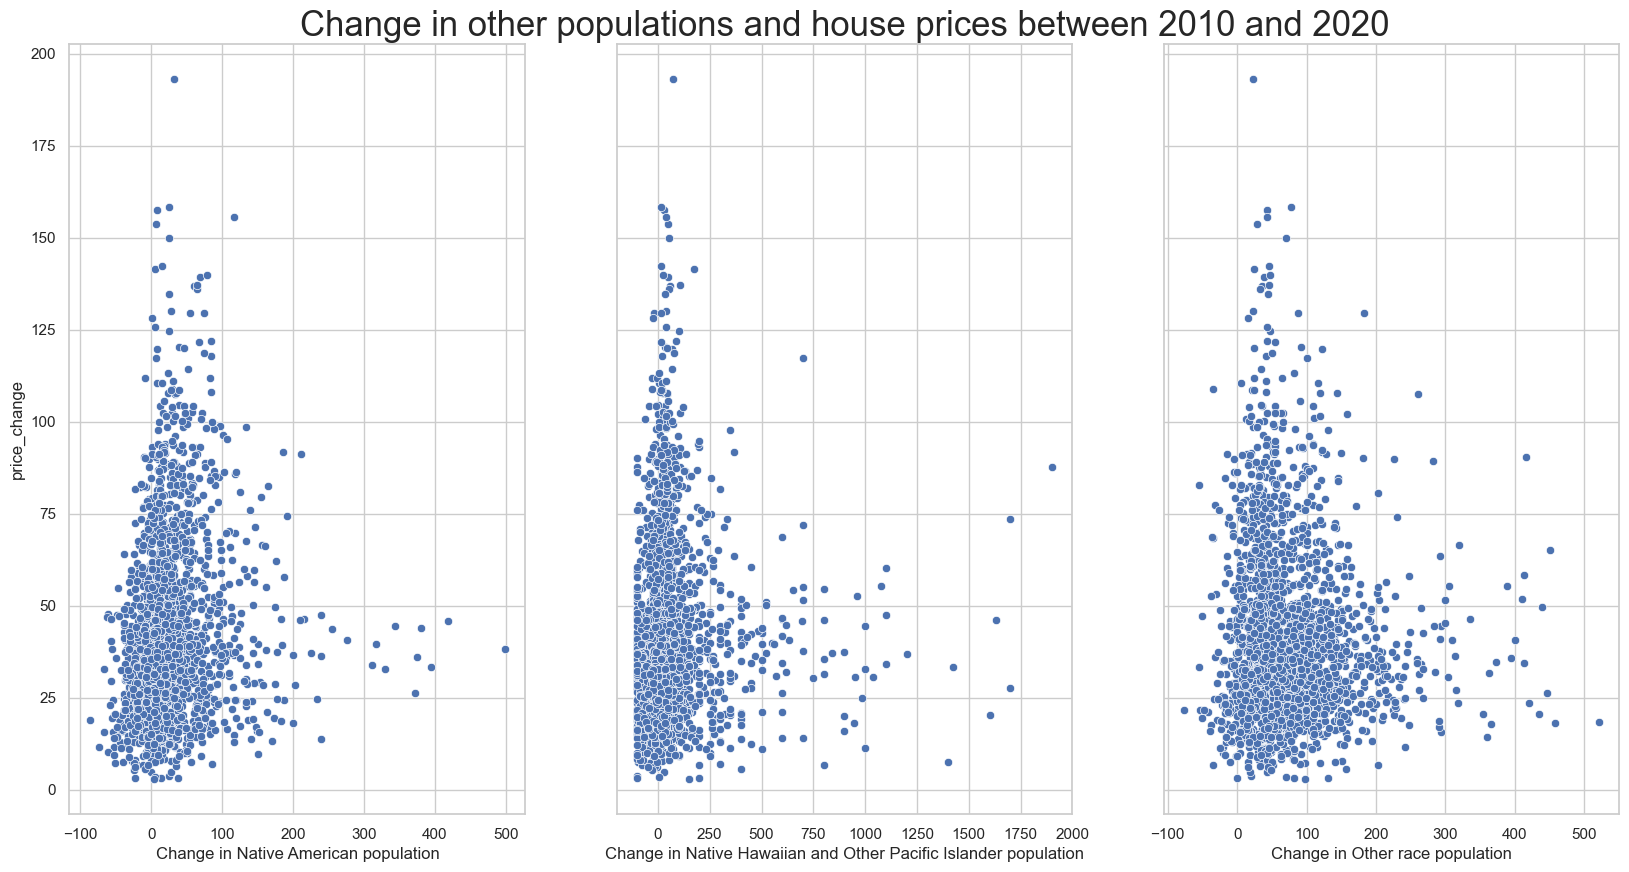

In [294]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,10))
sns.scatterplot(combined.query('na_change<600'), x='na_change', y='price_change', ax=ax1)
sns.scatterplot(combined.query('ha_change<2000'), x='ha_change', y='price_change', ax=ax2)
sns.scatterplot(combined.query('o_change<600'), x='o_change', y='price_change', ax=ax3)
ax1.set_xlabel('Change in Native American population')
ax2.set_xlabel('Change in Native Hawaiian and Other Pacific Islander population')
ax3.set_xlabel('Change in Other race population')
ax2.set_title('Change in other populations and house prices between 2010 and 2020', loc='center', fontsize=25)
plt.show()

Because these groups only take up a very few proportions of each county's population, there are some big outliers in the graph, and I need to filter some of them, and they have some similar distribution compared to Asian and black. However, we will ignore them for some analysis because they only make up a small portion of the population.

In [295]:
print(combined.as_20.sum()/combined.total_20.sum()*100)
print(stats.percentileofscore(combined['as_20'],100000))

6.295405570279994
98.17823732151649


In [296]:
print(combined.query('as_20>100000').total_20.median())
print(stats.percentileofscore(combined['total_20'],1603797))

1603797.0
99.01526341703594


Looking at the data for this project, Asians took up about 6.3% of the total population in 2020. Although I only included one race, instead of some populations with two or more racial backgrounds, this number is very close to census data which is 6.2%. I want to look at the counties with Asian population higher than 100,000, which is around 98.2% percentile. And for counties with Asian population higher than 100,000, their median population is around 1.6 million in 2020.

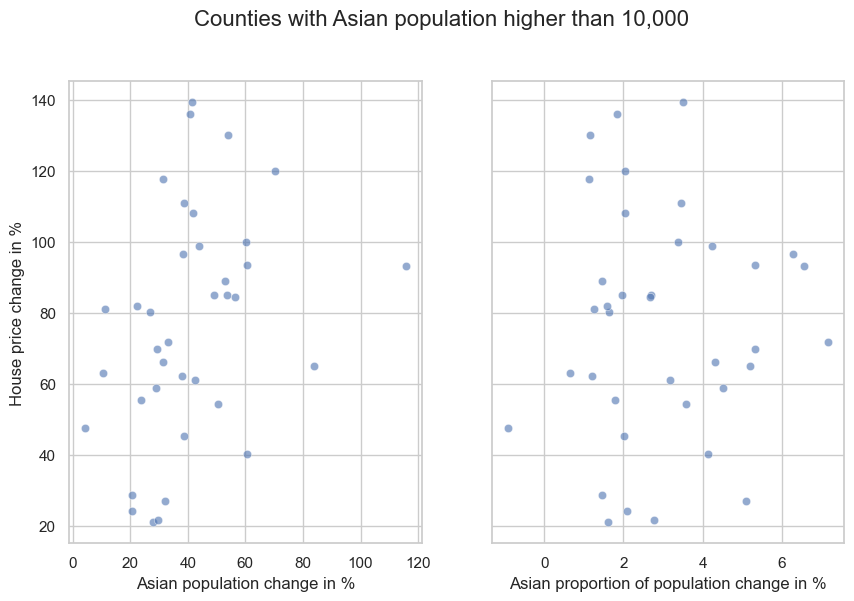

In [297]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined.query('as_20>100000'), x='as_change', y='price_change', alpha = 0.6, ax = ax1)
sns.scatterplot(combined.query('as_20>100000'), x='as_p_change_20', y='price_change', alpha = 0.6, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Counties with Asian population higher than 10,000 ', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
plt.show()

In [298]:
pg.corr(combined.query('as_20>100000')['as_change'],combined.query('as_20>100000')['price_change'] )

,n,r,CI95%,p-val,BF10,power
pearson,37,0.346343,"[0.03, 0.6]",0.035738,1.709,0.567947


In [299]:
pg.corr(combined.query('as_20>100000')['as_p_change_20'],combined.query('as_20>100000')['price_change'] )

,n,r,CI95%,p-val,BF10,power
pearson,37,0.02386,"[-0.3, 0.35]",0.888521,0.207,0.051851


From the previous graphs created, we could not see a strong enough relationship when we look at all the counties in the US. What about counties with a higher population, since a small population in 2010 can make the percentage change very different compared to the already big Asian population? So I am now looking at the 37 counties with an Asian population higher than 100,000, from the scatter plot, there is a stronger positive relationship between Asian population change and house price change. The R we got is 0.346, which is moderate. So by looking at the Asian population alone, it looks like big counties will have a higher correlation, what about other races? So I will now group all counties into three categoties based on total population in 2020 to find out the different relationship.

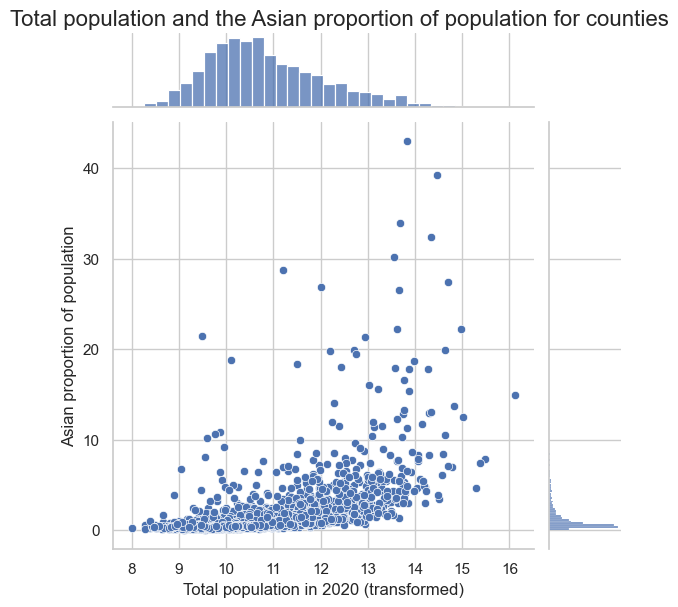

In [300]:
sns.jointplot(combined, x=np.log(combined['total_20']), y='as_p_20')
plt.suptitle('Total population and the Asian proportion of population for counties', y=1.01, fontsize=16)
plt.xlabel('Total population in 2020 (transformed)')
plt.ylabel('Asian proportion of population')
plt.show()

proportion of population

In [301]:
print(combined.total_20.quantile(0.25))
print(combined.total_20.quantile(0.75))
print(combined.total_20.quantile(0.94))

20736.5
108697.0
499622.19999999914


After comparing with the histogram of the population and quantiles, I will use:
    small = population less than 20,000, which is around Q1
    medium = population less than 100,000 and above 20,000, which is around Q3
    large = population less than 500,000 and above 100,000, which is around 94% percentile
    very_large = population above 500,000

In [302]:
category_labels = ['small', 'medium', 'large', 'very_large']
bin_edges = [0, 20000, 100000, 500000, combined['total_20'].max()]
combined['county_size_20'] = pd.cut(combined['total_20'], bins=bin_edges, labels=category_labels)

In [303]:
combined.head()

,county,state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,...,hisp_p_20,wh_p_change_20,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,adj_price_change,county_size_20
0,Abbeville County,South Carolina,25417.0,24295.0,25126.0,23408.0,17691.0,16877.0,7187.0,6205.0,...,1.741099,-0.136053,-2.736116,-0.054955,0.005395,0.025605,0.390070,0.737833,-5.909859,medium
1,Acadia Parish,Louisiana,61773.0,57576.0,60957.0,55603.0,49127.0,44480.0,11175.0,9989.0,...,2.850146,-2.273861,-0.741185,0.000130,0.061324,-0.006239,0.854022,1.134186,-15.020617,medium
2,Accomack County,Virginia,33164.0,33413.0,32625.0,31655.0,21662.0,20261.0,9303.0,8670.0,...,10.265466,-4.679739,-2.103517,0.481808,0.211373,-0.108641,2.562549,1.671810,-17.189900,medium
3,Ada County,Idaho,392365.0,494967.0,381195.0,453110.0,354347.0,410263.0,4441.0,8058.0,...,9.136569,-7.423613,0.496133,-0.003739,0.416614,0.046842,0.858078,2.024568,113.358011,large
4,Adair County,Iowa,7682.0,7496.0,7630.0,7262.0,7558.0,7149.0,11.0,46.0,...,2.481323,-3.014973,0.470469,0.201399,0.020447,0.013663,-0.135763,1.166562,-0.554620,small


In [304]:
combined.groupby('county_size_20').size()

county_size_20
small          477
medium        1009
large          423
very_large     122
dtype: int64

Now we see there is 479 small county, 1010 medium county, 423 large counties, and 122 very large counties. Before doing everything, we want to find out whether there is a different distribution on price change for county size. By looking at the graph below, looking at the adjusted price change, except for county size, which is very large, they have a median slightly less than 0, which is the population median with a right-skewed distribution. But things changed for counties that are very large. Its median is higher than the population median and has a more uniform distribution. It is more fun to look at the very large counties.

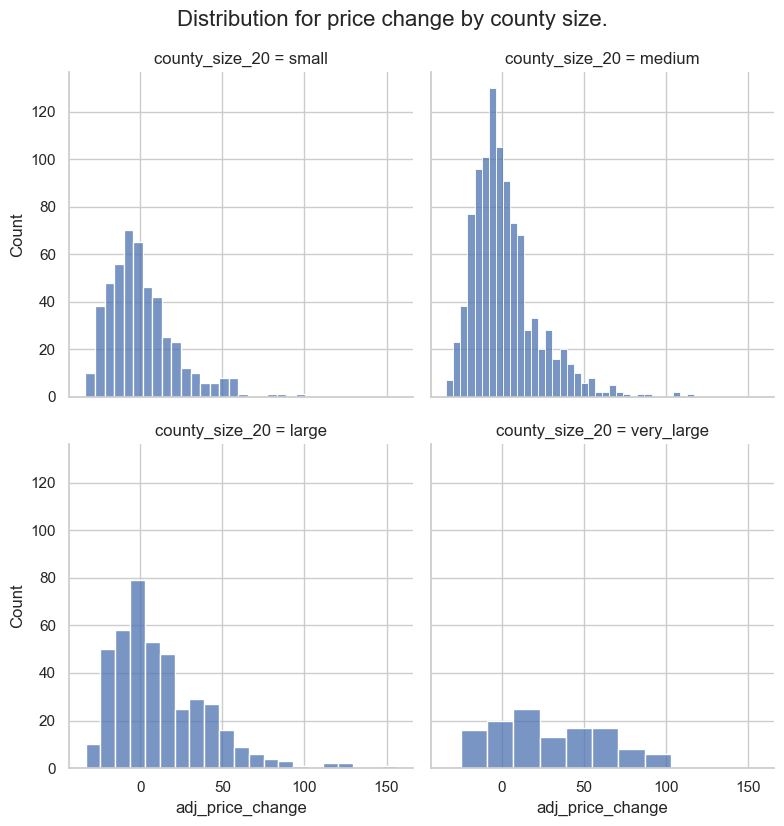

In [305]:
g = sns.FacetGrid(combined, col='county_size_20', height=4, col_wrap=2)
g.map(sns.histplot, "adj_price_change")
plt.suptitle('Distribution for price change by county size.', y = 1.03, fontsize = 16)
plt.show()

In [306]:
pg.kruskal(data=combined, dv='price_change', between='county_size_20',detailed=True).round(4)

,Source,ddof1,H,p-unc
Kruskal,county_size_20,3,124.6739,0.0


The Kruskal-Wallis test (since we have different distribution for each groups)supports our finding from the graph, in which the p-value is smaller than 0.01. There is strong evidence that indicates the mean price change is different between counties.

In [307]:
pg.pairwise_gameshowell(data=combined, dv='price_change', between='county_size_20').round(4)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,small,medium,37.5309,38.5182,-0.9873,1.1305,-0.8734,913.7996,0.8187,-0.0485
1,small,large,37.5309,48.8079,-11.2770,1.6643,-6.7757,760.7697,0.0000,-0.4522
2,small,very_large,37.5309,65.7312,-28.2004,3.0886,-9.1305,146.4947,0.0000,-0.9252
3,medium,large,38.5182,48.8079,-10.2897,1.5119,-6.8060,606.7383,0.0000,-0.3940
4,medium,very_large,38.5182,65.7312,-27.2131,3.0092,-9.0433,132.3128,0.0000,-0.8663
5,large,very_large,48.8079,65.7312,-16.9234,3.2477,-5.2110,177.1358,0.0000,-0.5348


After doing the post hoc test, we can see from the result that the very large counties do have a significant difference in mean house price change where all the p-value with very_large included is lower than 0.01.

Now we find enough evidence, we should zoom in and looking at the relationship in very large county only.

## Look at the relationship between population change and horse price change for counties with a very large population.

In [308]:
very_large = combined.query("county_size_20 == 'very_large'")

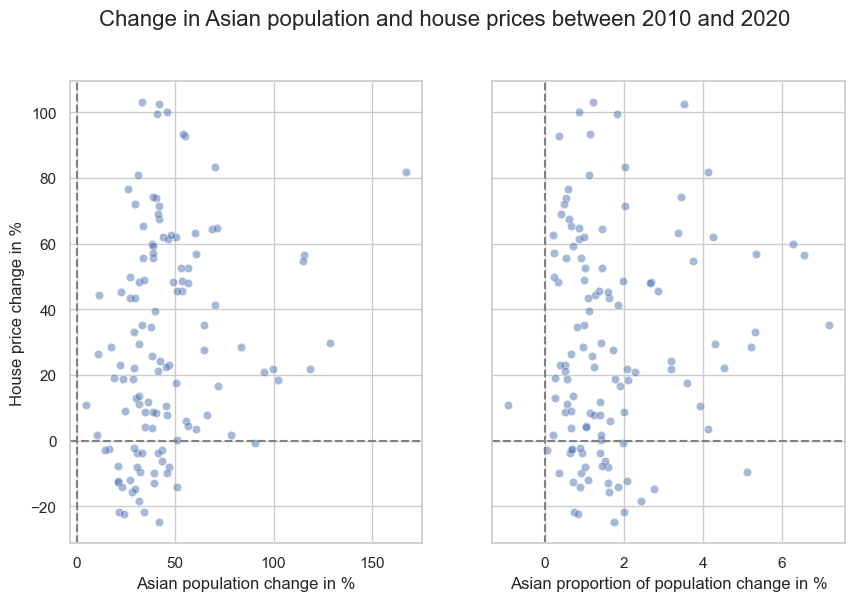

In [309]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='as_change', y='adj_price_change', alpha = 0.5, ax = ax1)
sns.scatterplot(very_large, x='as_p_change_20', y='adj_price_change', alpha = 0.5, ax = ax2)
sns.set_theme(style="whitegrid")
fig.suptitle('Change in Asian population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Asian population change in %')
ax2.set_xlabel('Asian proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

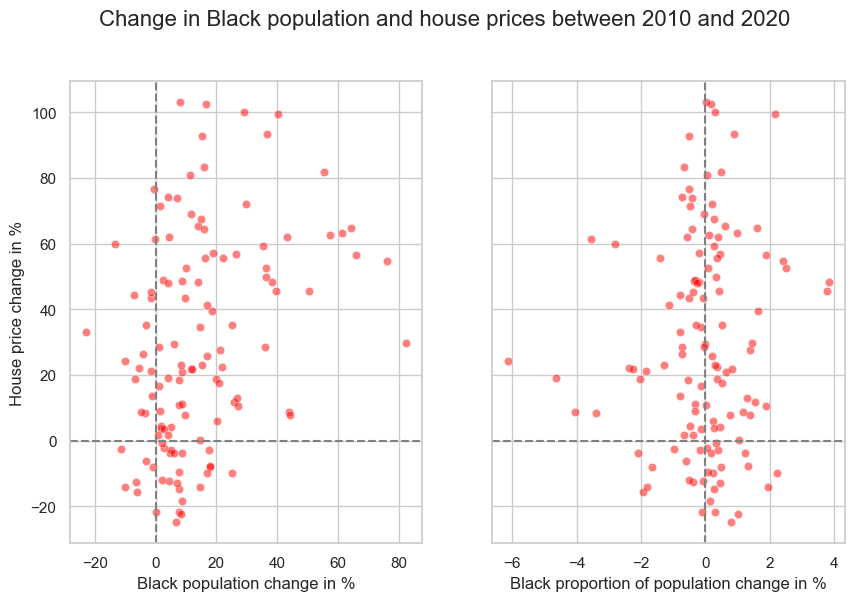

In [310]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='bl_change', y='adj_price_change', alpha = 0.5, color = 'red', ax = ax1)
sns.scatterplot(very_large, x='bl_p_change_20', y='adj_price_change', alpha = 0.5, color = 'red',ax = ax2)
fig.suptitle('Change in Black population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('Black population change in %')
ax2.set_xlabel('Black proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

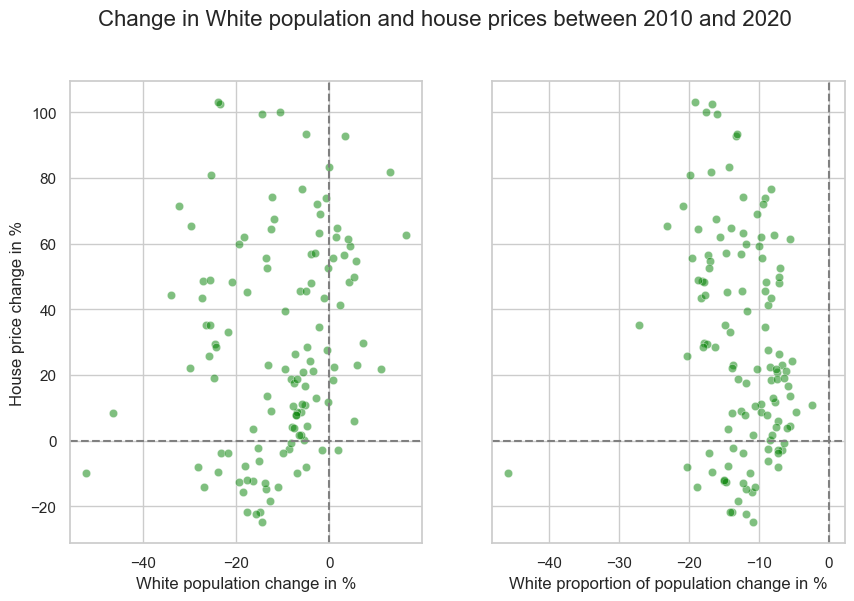

In [311]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(very_large, x='wh_change', y='adj_price_change', alpha = 0.5, color = 'green', ax = ax1)
sns.scatterplot(very_large, x='wh_p_change_20', y='adj_price_change', alpha = 0.5, color = 'green',ax = ax2)
fig.suptitle('Change in White population and house prices between 2010 and 2020', y=1, fontsize=16)
ax1.set_xlabel('White population change in %')
ax2.set_xlabel('White proportion of population change in %')
ax1.set_ylabel('House price change in %')
ax1.axhline(0, linestyle= '--', c='grey')
ax1.axvline(0, linestyle= '--', c='grey')
ax2.axhline(0, linestyle= '--', c='grey')
ax2.axvline(0, linestyle= '--', c='grey')
plt.show()

In [312]:
pg.linear_regression(very_large[['wh_change','as_change','bl_change']], very_large['price_change']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,55.3034,7.6781,7.2027,0.0000,0.1253,0.1031,40.0986,70.5082
1,wh_change,0.0283,0.2788,0.1014,0.9194,0.1253,0.1031,-0.5238,0.5804
2,as_change,0.0599,0.1332,0.4499,0.6536,0.1253,0.1031,-0.2038,0.3237
3,bl_change,0.5578,0.1846,3.0217,0.0031,0.1253,0.1031,0.1923,0.9234


What a surprising result! The coefficient for change in the black population is most significant compared to the change in the white and Asian populations. Where the p-value for wh_change and as_change is higher than 0.1, we can say there is little to no evidence that in counties that have a population higher than half-million, there is a correlation between change in population for white and Asian, but for change in the black population, the coefficient is 0.5578, and the p-value is 0.0031, which is less than 0.1, we can say there is very strong evidence that change in black population has a positive impact on price change.

In [313]:
pg.linear_regression(very_large[['wh_p_change_20','as_p_change_20','bl_p_change_20']], very_large['price_change']).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,51.5663,7.6741,6.7196,0.0000,0.0374,0.0129,36.3696,66.7630
1,wh_p_change_20,-0.9050,0.5437,-1.6644,0.0987,0.0374,0.0129,-1.9817,0.1718
2,as_p_change_20,1.7893,2.0186,0.8864,0.3772,0.0374,0.0129,-2.2082,5.7867
3,bl_p_change_20,0.9216,2.0908,0.4408,0.6602,0.0374,0.0129,-3.2188,5.0620


proportion of population

## Overall view: racial demographics and house price

In [314]:
price = pd.read_csv('uscensus_data/ACSST5Y2020.S2506-2023-02-11T231305.csv',header=[0,1])
price = price.T.reset_index().drop(index = 0).iloc[::2, :].iloc[:,[0,10]].reset_index(drop=True)
df = price.iloc[:,0].str.replace('!!Owner-occupied housing units with a mortgage!!Estimate', '').str.split(', ', expand = True)
df = df.merge(states_index, left_on = df.iloc[:,1], right_on = 'Full')
df['county_state'] = (df.iloc[:,0]+'_'+df.iloc[:,-1]).str.replace(' ','_')
price = price.merge(df['county_state'], left_index=True,right_index=True,how='left').drop(columns = 'level_0')
price.columns = ['median_p', 'county_state']
price['median_p'] = price.median_p.str.replace(',','')
price = price.drop(price[price['median_p'] == '-'].index)
price['median_p'] = pd.to_numeric(price['median_p'])

In [315]:
combined = combined.merge(price, on = 'county_state')

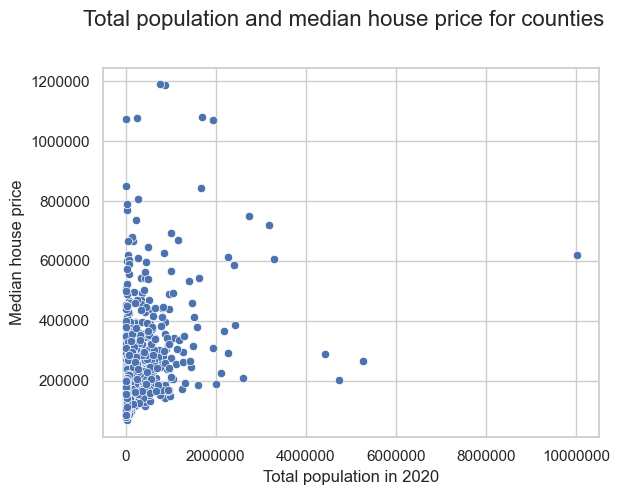

In [316]:
sns.scatterplot(combined, x=combined['total_20'], y=combined['median_p'])
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.suptitle('Total population and median house price for counties', y=1, fontsize=16)
plt.xlabel('Total population in 2020')
plt.ylabel('Median house price')
plt.show()

That doesn't show us too much relationship between total population and median house price. It makes sense that some small counties with many mansions will have a high median house price. Now we need to transform them using log, and we will be able to see a much strong relationship.

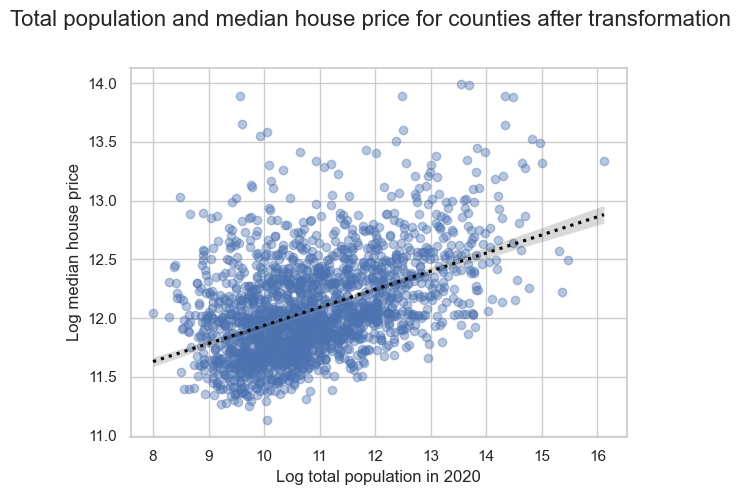

In [317]:
sns.regplot(combined, x=np.log(combined['total_20']), y=np.log(combined['median_p']), scatter_kws={"alpha": 0.4}, line_kws={"color": "black", 'linestyle':':'})
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.suptitle('Total population and median house price for counties after transformation', y=1, fontsize=16)
plt.xlabel('Log total population in 2020')
plt.ylabel('Log median house price')
plt.show()

In [318]:
pg.corr(np.log(combined['total_20']), np.log(combined['median_p']))

,n,r,CI95%,p-val,BF10,power
pearson,2031,0.465616,"[0.43, 0.5]",8.207937e-110,1.008e+106,1.0


In [319]:
pg.linear_regression(np.log(combined['total_20']), np.log(combined['median_p'])).round(4)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,10.3994,0.0710,146.5089,0.0,0.2168,0.2164,10.2601,10.5386
1,total_20,0.1539,0.0065,23.6991,0.0,0.2168,0.2164,0.1412,0.1666


Finally! After trying different stuff, we see a practical OLS model. We got a p-value that is much smaller than 0.01, indicating that we have very strong evidence against the null hypothesis that there is no relationship between the percentage change in total population for counties in 2020 and the percentage change in median house prices in 2020. From the result above, we can estimate that when there is a 1% change in the total population, the median house price will go up by 0.15%.

Since my main goal is to find the relationship between racial demographics and house prices, let's take a look at the Asian population's proportion and house prices. From the graph below, we can see some positive, linear relationships between them. However, the data cluster in between 0 - 10 percent of the county population; we should try something else, like only looking at counties with very big populations.

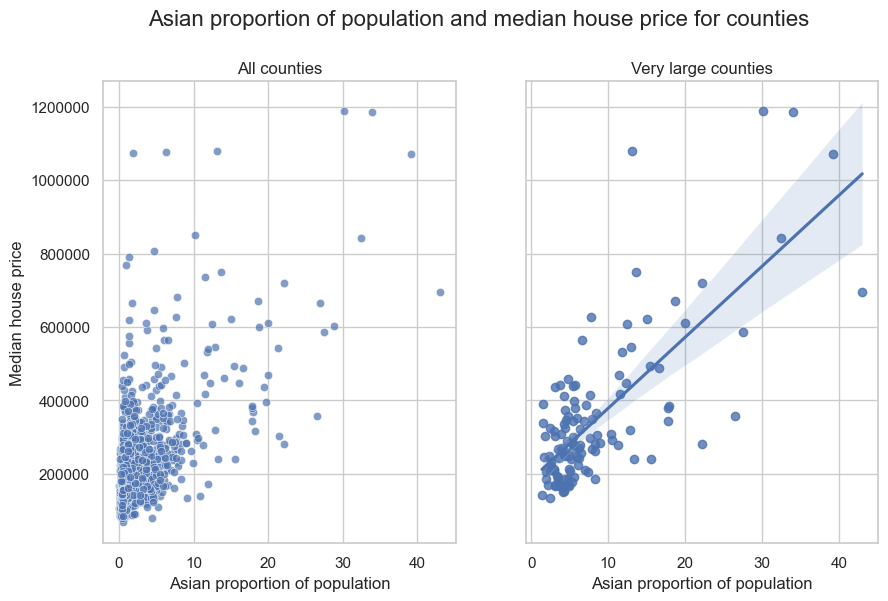

In [320]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x=combined['as_p_20'], y=combined['median_p'], alpha = 0.7, ax = ax1)
sns.regplot(combined, x=combined.query("county_size_20 == 'very_large'")['as_p_20'], y=combined.query("county_size_20 == 'very_large'")['median_p'], ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Asian proportion of population and median house price for counties', y=1, fontsize=16)
ax1.set_title('All counties', y=1, fontsize=12)
ax2.set_title('Very large counties', y=1, fontsize=12)
ax1.set_xlabel('Asian proportion of population')
ax2.set_xlabel('Asian proportion of population')
ax1.set_ylabel('Median house price')
ax2.set_ylabel('')
plt.show()

Now it looks good!

In [321]:
pg.corr(combined.query("county_size_20 == 'very_large'")['as_p_20'], combined.query("county_size_20 == 'very_large'")['median_p'])

,n,r,CI95%,p-val,BF10,power
pearson,122,0.741603,"[0.65, 0.81]",1.522676e-22,3.325e+19,1.0


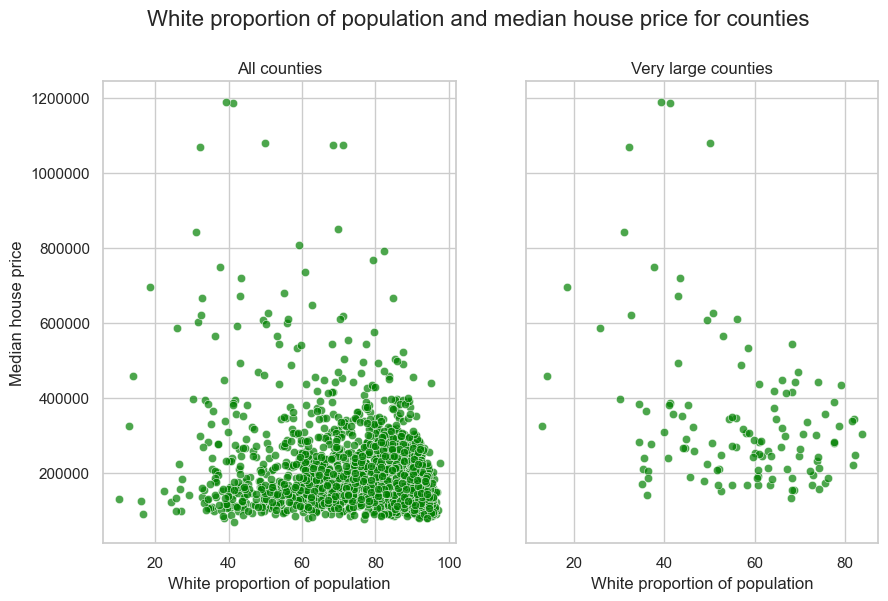

In [322]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x=combined['wh_p_20'], y=combined['median_p'], alpha = 0.7, ax = ax1, color = 'green')
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['wh_p_20'], y=combined.query("county_size_20 == 'very_large'")['median_p'], alpha = 0.7, color = 'green', ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('White proportion of population and median house price for counties', y=1, fontsize=16)
ax1.set_title('All counties', y=1, fontsize=12)
ax2.set_title('Very large counties', y=1, fontsize=12)
ax1.set_xlabel('White proportion of population')
ax2.set_xlabel('White proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

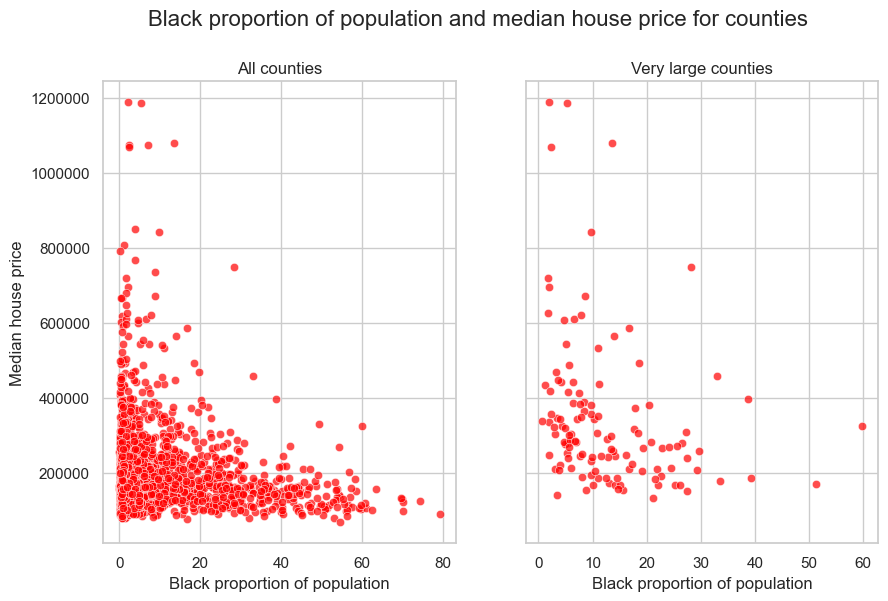

In [323]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x=combined['bl_p_20'], y=combined['median_p'], alpha = 0.7, ax = ax1, color = 'red')
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['bl_p_20'], y=combined.query("county_size_20 == 'very_large'")['median_p'], alpha = 0.7, color = 'red', ax = ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Black proportion of population and median house price for counties', y=1, fontsize=16)
ax1.set_title('All counties', y=1, fontsize=12)
ax2.set_title('Very large counties', y=1, fontsize=12)
ax1.set_xlabel('Black proportion of population')
ax2.set_xlabel('Black proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

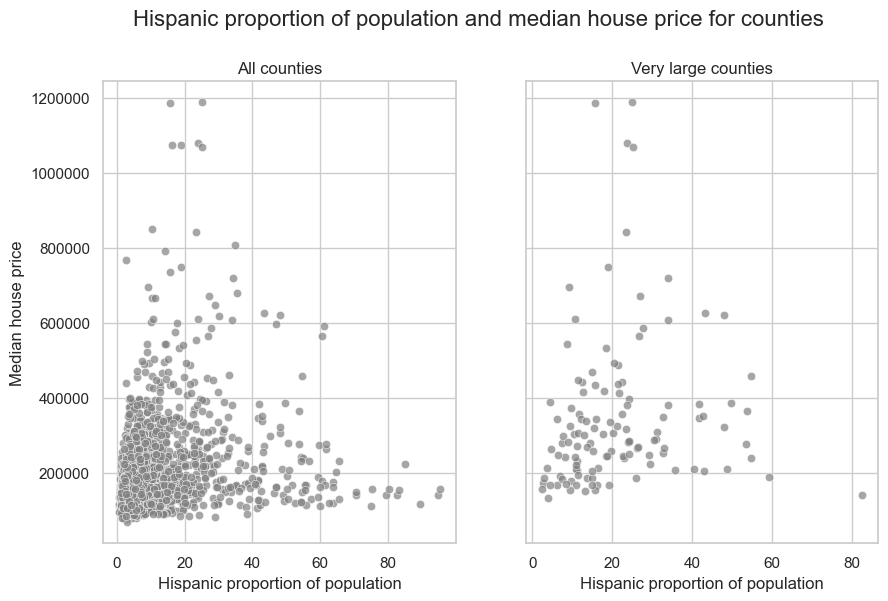

In [359]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x=combined['hisp_p_20'], y=combined['median_p'], alpha=0.7, ax=ax1, color='grey')
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['hisp_p_20'],
                y=combined.query("county_size_20 == 'very_large'")['median_p'], alpha=0.7, color='grey', ax=ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Hispanic proportion of population and median house price for counties', y=1, fontsize=16)
ax1.set_title('All counties', y=1, fontsize=12)
ax2.set_title('Very large counties', y=1, fontsize=12)
ax1.set_xlabel('Hispanic proportion of population')
ax2.set_xlabel('Hispanic proportion of population')
ax1.set_ylabel('Median house price')
plt.show()

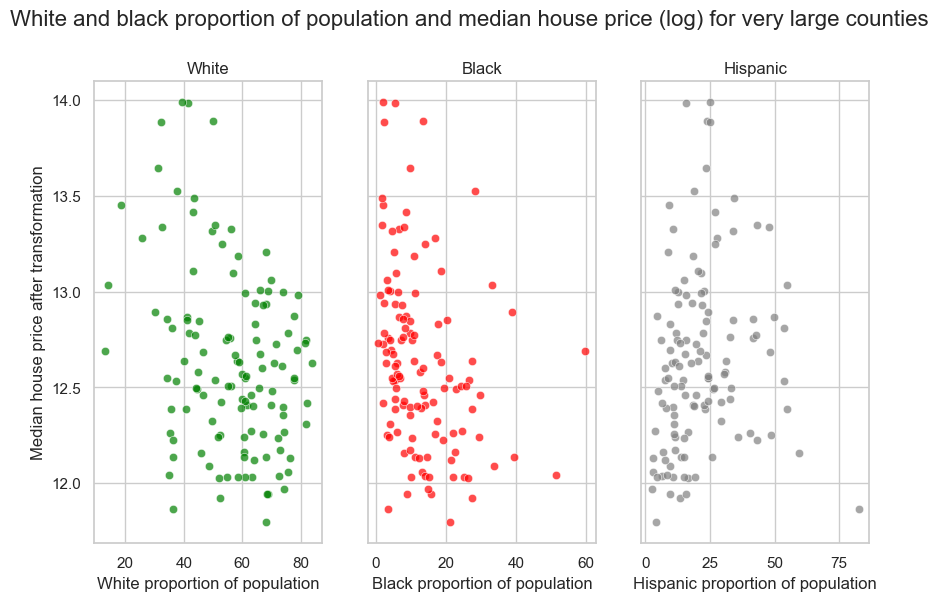

In [362]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(10,6))
ax1.grid(visible=True)
ax2.grid(visible=True)
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['wh_p_20'], y=np.log(combined.query("county_size_20 == 'very_large'")['median_p']), alpha = 0.7, color = 'green', ax =ax1)
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['bl_p_20'], y=np.log(combined.query("county_size_20 == 'very_large'")['median_p']), alpha = 0.7, color = 'red', ax =ax2)
sns.scatterplot(combined, x=combined.query("county_size_20 == 'very_large'")['hisp_p_20'], y=np.log(combined.query("county_size_20 == 'very_large'")['median_p']), alpha = 0.7, color = 'grey', ax =ax3)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('White and black proportion of population and median house price (log) for very large counties', y=1, fontsize=16)
ax1.set_title('White', y=1, fontsize=12)
ax2.set_title('Black', y=1, fontsize=12)
ax3.set_title('Hispanic', y=1, fontsize=12)
ax1.set_xlabel('White proportion of population')
ax2.set_xlabel('Black proportion of population')
ax3.set_xlabel('Hispanic proportion of population')
ax1.set_ylabel('Median house price after transformation')
plt.show()

In [325]:
print('Correlation between white proportion of population and change in house price in very large counties:\n', pg.corr(x=combined.query("county_size_20 == 'very_large'")['wh_p_20'], y=combined.query("county_size_20 == 'very_large'")['median_p']),'\n')
print('Correlation between black proportion of population and change in house price in very large counties:\n', pg.corr(x=combined.query("county_size_20 == 'very_large'")['bl_p_20'], y=combined.query("county_size_20 == 'very_large'")['median_p']))

Correlation between white proportion of population and change in house price in very large counties:
            n         r           CI95%    p-val     BF10    power
pearson  122 -0.339574  [-0.49, -0.17]  0.00013  156.728  0.97204 

Correlation between black proportion of population and change in house price in very large counties:
            n         r           CI95%     p-val   BF10     power
pearson  122 -0.265188  [-0.42, -0.09]  0.003157  8.386  0.844842


In [326]:
print('Correlation between white proportion of population and percentage change in house price in very large counties:\n', pg.corr(x=combined.query("county_size_20 == 'very_large'")['wh_p_20'], y=np.log(combined.query("county_size_20 == 'very_large'")['median_p'])),'\n')
print('Correlation between black proportion of population and percentage change in house price in very large counties:\n', pg.corr(x=combined.query("county_size_20 == 'very_large'")['bl_p_20'], y=np.log(combined.query("county_size_20 == 'very_large'")['median_p'])))

Correlation between white proportion of population and percentage change in house price in very large counties:
            n         r           CI95%    p-val    BF10     power
pearson  122 -0.311915  [-0.46, -0.14]  0.00047  47.666  0.942122 

Correlation between black proportion of population and percentage change in house price in very large counties:
            n         r           CI95%     p-val    BF10     power
pearson  122 -0.308445  [-0.46, -0.14]  0.000547  41.414  0.937091


The result for the Asian proportion of the population can be identified as a strong, positive, and linear relationship with median house prices, but what about the white and black groups? The result looks like there is a weak, negative, linear relationship between the proportion of the population and the change in median house prices. For both original data and transformed data, it looks like there is a slightly higher correlation between the white proportion of the population to the black proportion of the population.

## Machine learning practice: predict house price level by racial demographics

We want to ask python to predict the price level, it will be a discrete categorical data, so we need to put median house price for each county into group.

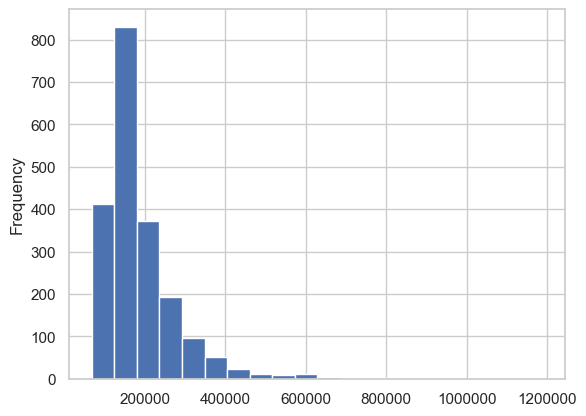

In [327]:
combined.median_p.plot(kind = 'hist', bins = 20)
plt.ticklabel_format(style='plain', axis='x')

In [328]:
combined.median_p.quantile(0.96)

394880.0

After comparing with the histogram of the median house price, I will use:
    lowest = median house price less than 150,000, which is around 40% percentile
    low = median house price less than 200,000 and above 150,000, which is around 70% percentile
    medium = median house price less than 300,000 and above 200,000, which is around 90% percentile
    high = median house price less than 400,000 and above 300,000, which is around 96% percentile
    very_large = population above 400,000

In [329]:
category_labels = ['lowest', 'low', 'medium','high', 'highest']
bin_edges = [0, 150000, 200000, 300000, 400000, combined['median_p'].max()]
combined['price_level'] = pd.cut(combined['median_p'], bins=bin_edges, labels=category_labels)

In [330]:
combined.head()

,county,state,total_10,total_20,total_one_10,total_one_20,wh_10,wh_20,bl_10,bl_20,...,bl_p_change_20,na_p_change_20,as_p_change_20,ha_p_change_20,o_p_change_20,hisp_p_change_20,adj_price_change,county_size_20,median_p,price_level
0,Abbeville County,South Carolina,25417.0,24295.0,25126.0,23408.0,17691.0,16877.0,7187.0,6205.0,...,-2.736116,-0.054955,0.005395,0.025605,0.390070,0.737833,-5.909859,medium,107000,lowest
1,Acadia Parish,Louisiana,61773.0,57576.0,60957.0,55603.0,49127.0,44480.0,11175.0,9989.0,...,-0.741185,0.000130,0.061324,-0.006239,0.854022,1.134186,-15.020617,medium,169900,low
2,Accomack County,Virginia,33164.0,33413.0,32625.0,31655.0,21662.0,20261.0,9303.0,8670.0,...,-2.103517,0.481808,0.211373,-0.108641,2.562549,1.671810,-17.189900,medium,193500,low
3,Ada County,Idaho,392365.0,494967.0,381195.0,453110.0,354347.0,410263.0,4441.0,8058.0,...,0.496133,-0.003739,0.416614,0.046842,0.858078,2.024568,113.358011,large,301400,high
4,Adair County,Iowa,7682.0,7496.0,7630.0,7262.0,7558.0,7149.0,11.0,46.0,...,0.470469,0.201399,0.020447,0.013663,-0.135763,1.166562,-0.554620,small,115000,lowest


In [331]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [386]:
combined['state_code'] = combined.state.astype('category').cat.codes
combined['size_code'] = combined.county_size_20.astype('category').cat.codes

In [391]:
features = ['state_code','size_code','wh_p_20','bl_p_20','as_p_20','hisp_p_20']
X = combined[features]
y = combined['price_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [392]:
dtc_model = DecisionTreeClassifier(random_state = 1)
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("DTC Accuracy: {:.2f}%".format(accuracy*100))

DTC Accuracy: 46.23%


In [356]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
max_features = ['sqrt', 'log2']
criterion = ['gini', 'entropy']

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator = rf, param_distributions = {'n_estimators': n_estimators,
                                               'max_depth': max_depth,
                                               'min_samples_split': min_samples_split,
                                               'max_features': max_features,
                                               'criterion': criterion},
                          n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 500, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'gini'}


In [393]:
rf_model = RandomForestClassifier(random_state = 2, n_estimators = 500, min_samples_split = 10, max_features = 'log2', max_depth =90, criterion = 'gini')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("RF Accuracy: {:.2f}%".format(accuracy*100))

RF Accuracy: 54.26%


In [383]:
rf_model.predict([[1,71,11.1,7.6,0.02,0.03,5.5, 90]])

/Users/frederickchen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['medium'], dtype=object)

In [385]:
X_test.head()

,state_code,wh_p_20,bl_p_20,as_p_20,ha_p_20,na_p_20,o_p_20,hisp_p_20
711,21,86.223989,5.359067,0.392711,0.074232,0.474127,2.760949,7.550107
250,16,89.562293,3.042675,1.110920,0.032232,0.218101,1.206541,2.480768
1115,15,73.964387,2.023059,1.783772,0.049722,0.826626,11.728146,22.548867
164,17,62.954966,23.378590,1.861029,0.092430,0.619048,3.843226,7.951315
1987,12,66.978798,13.723147,2.817242,0.029438,0.571929,6.679166,14.351498


In [394]:
k_range = range(1, 50)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

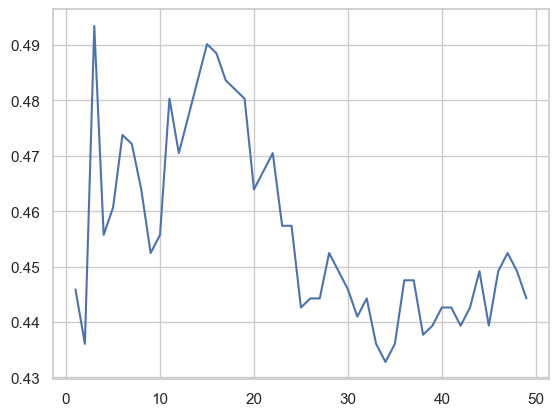

In [395]:
plt.plot(k_range, scores)